# Generative AI Assignment # 1

### Muhammad Abdullah Atif
### BSDS-8A/21L-6225

# A Comparative Implementation of GANs vs VAEs
### - Analysis summary on Image Quality, Training Stability and Latent Space Representation
### - Dealing with a real-world problem of Phishing web-pages detection

# Part 1

## Importing required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
torch.manual_seed(42)
np.random.seed(42)

## Loading and Preparing datasets

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_digits_train = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
mnist_digits_test = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=False, transform=transform)
mnist_digits_loader = torch.utils.data.DataLoader(mnist_digits_train, batch_size=64,
                                                shuffle=True)

mnist_fashion_train = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                download=True, transform=transform)
mnist_fashion_test = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                download=False, transform=transform)
mnist_fashion_loader = torch.utils.data.DataLoader(mnist_fashion_train, batch_size=64,
                                                shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.40MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.83MB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 54.3MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 16.0MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Utility functions

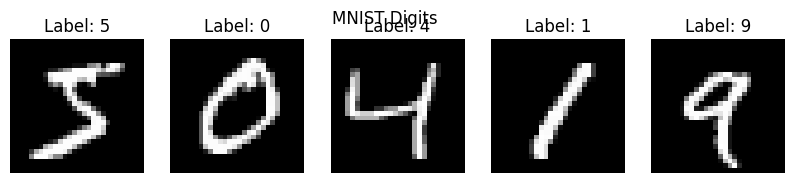

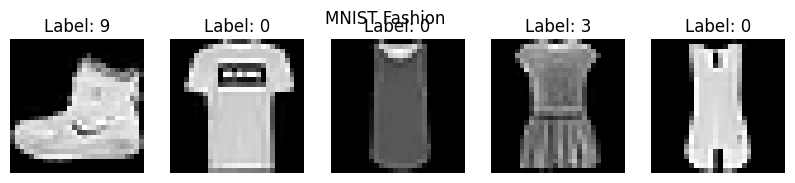

In [3]:
def show_images(images, num_images=10, size=(28, 28), titles=None):
    fig = plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].reshape(size), cmap='gray')
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def display_images(dataset, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()

# Generic function to visualize latent space for GAN or VAE
def visualize_latent_space(model, dataloader, model_type='gan', latent_dim=100, num_samples=1000, device='cuda'):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for real_images, real_labels in dataloader:
            batch_size = real_images.size(0)
            if len(latent_vectors) >= num_samples:
                break

            if model_type == 'gan':
                z = torch.randn(batch_size, latent_dim).to(device)
                latent_vectors.append(z.cpu().numpy())
            elif model_type == 'vae':
                real_images = real_images.to(device)
                mu, _ = model.encode(real_images.view(-1, 784))
                latent_vectors.append(mu.cpu().numpy())
            else:
                raise ValueError("model_type must be 'gan' or 'vae'")

            labels.append(real_labels.numpy())

    latent_vectors = np.concatenate(latent_vectors)[:num_samples]
    labels = np.concatenate(labels)[:num_samples]

    pca = PCA(n_components=2, random_state=42)
    latent_2d = pca.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=10)
    plt.colorbar(scatter, label='Class Label')
    plt.title(f'{model_type.upper()} Latent Space Visualization (PCA)')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.show()

display_images(mnist_digits_train, "MNIST Digits")

display_images(mnist_fashion_train, "MNIST Fashion")

## Dimensions/ Samples for Training/Testing

In [4]:
print("MNIST Digits:")
print(f"Number of training samples: {len(mnist_digits_train)}")
print(f"Number of testing samples: {len(mnist_digits_test)}")
print(f"Number of classes: {len(mnist_digits_train.classes)}")
print(f"Class labels: {mnist_digits_train.classes}")

print("\nMNIST Fashion:")
print(f"Number of training samples: {len(mnist_fashion_train)}")
print(f"Number of testing samples: {len(mnist_fashion_test)}")
print(f"Number of classes: {len(mnist_fashion_train.classes)}")
print(f"Class labels: {mnist_fashion_train.classes}")

MNIST Digits:
Number of training samples: 60000
Number of testing samples: 60000
Number of classes: 10
Class labels: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

MNIST Fashion:
Number of training samples: 60000
Number of testing samples: 60000
Number of classes: 10
Class labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Part 2

## GAN Implementation

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Initial layer
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),

            # Hidden layers
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            # Output layer
            nn.Linear(1024, 784),  # 28x28 = 784
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input layer
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Hidden layers
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Output layer
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(-1, 784)
        return self.model(img_flat)

## Training GANs function

In [6]:
def train_gan(generator, discriminator, dataloader, num_epochs=20, latent_dim=100,
              device='cuda' if torch.cuda.is_available() else 'cpu'):

    # Initialize optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    g_losses = []
    d_losses = []

    generator.to(device)
    discriminator.to(device)

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            d_optimizer.zero_grad()
            label_real = torch.ones(batch_size, 1).to(device)
            label_fake = torch.zeros(batch_size, 1).to(device)

            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            output_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(output_fake, label_fake)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            g_optimizer.zero_grad()
            output_fake = discriminator(fake_images)
            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            g_optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    return g_losses, d_losses

## Training GANs on MNIST Digits dataset

Epoch [1/20], d_loss: 0.5683974027633667, g_loss: 4.788311958312988
Epoch [2/20], d_loss: 0.8700127601623535, g_loss: 6.4511566162109375
Epoch [3/20], d_loss: 0.5842593908309937, g_loss: 2.7053329944610596
Epoch [4/20], d_loss: 0.5076937675476074, g_loss: 2.042489528656006
Epoch [5/20], d_loss: 1.3441321849822998, g_loss: 1.5954127311706543
Epoch [6/20], d_loss: 0.9281514883041382, g_loss: 1.7297353744506836
Epoch [7/20], d_loss: 1.1886845827102661, g_loss: 1.4159672260284424
Epoch [8/20], d_loss: 0.832851231098175, g_loss: 1.3968286514282227
Epoch [9/20], d_loss: 1.5412943363189697, g_loss: 0.8971762657165527
Epoch [10/20], d_loss: 1.12704336643219, g_loss: 1.2773113250732422
Epoch [11/20], d_loss: 1.2605359554290771, g_loss: 1.3310530185699463
Epoch [12/20], d_loss: 1.0970652103424072, g_loss: 1.099792718887329
Epoch [13/20], d_loss: 1.1552841663360596, g_loss: 1.321945309638977
Epoch [14/20], d_loss: 1.1577703952789307, g_loss: 1.18147873878479
Epoch [15/20], d_loss: 1.2321829795837

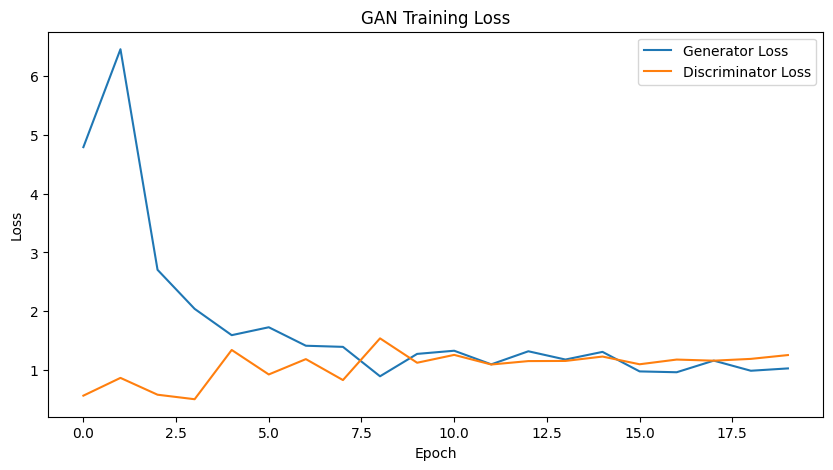

Visualizing Latent Space for GAN (MNIST Digits)...


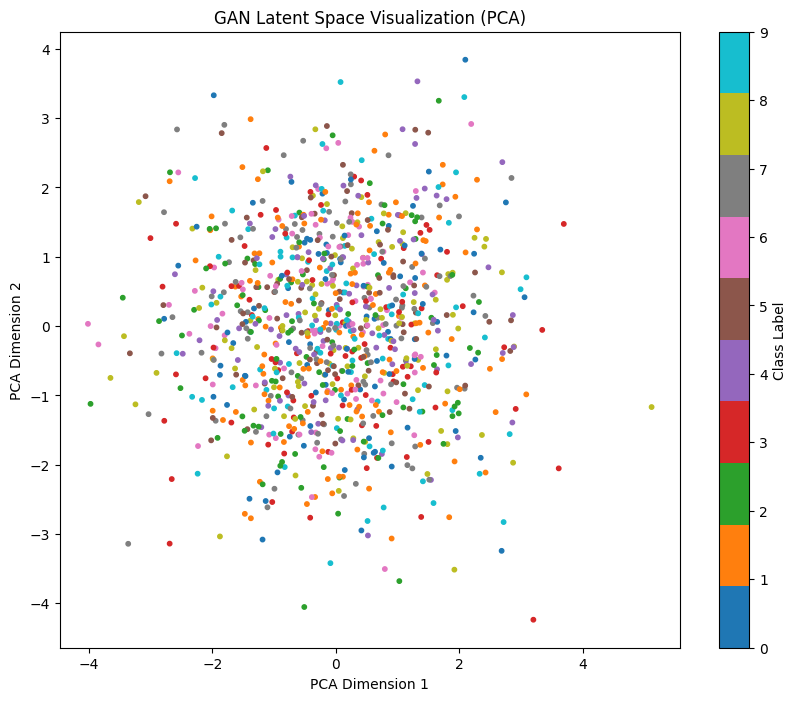

In [7]:
latent_dim = 100
generator = Generator(latent_dim)
discriminator = Discriminator()

g_losses, d_losses = train_gan(generator, discriminator, mnist_digits_loader, num_epochs=20)

plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Training Loss')
plt.show()

print("Visualizing Latent Space for GAN (MNIST Digits)...")
visualize_latent_space(generator, mnist_digits_loader, model_type='gan', latent_dim=100, num_samples=1000)

## Some use cases such as
- Generating 10 random images
- Generating specific digit images e:g 5

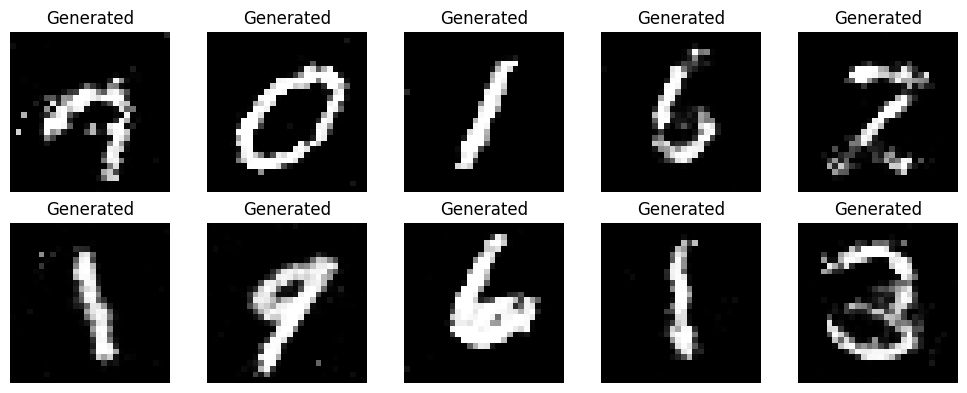

Epoch [1/20], d_loss: 1.4954421520233154, g_loss: 0.6061161756515503
Epoch [2/20], d_loss: 0.5287037491798401, g_loss: 1.623521327972412
Epoch [3/20], d_loss: 1.789397954940796, g_loss: 1.9849706888198853
Epoch [4/20], d_loss: 0.5855638980865479, g_loss: 3.346827983856201
Epoch [5/20], d_loss: 0.6262437105178833, g_loss: 1.9176832437515259
Epoch [6/20], d_loss: 0.6927807331085205, g_loss: 1.6533135175704956
Epoch [7/20], d_loss: 1.0038896799087524, g_loss: 1.2239505052566528
Epoch [8/20], d_loss: 1.8377741575241089, g_loss: 1.4385571479797363
Epoch [9/20], d_loss: 1.6762092113494873, g_loss: 2.2810401916503906
Epoch [10/20], d_loss: 1.055901050567627, g_loss: 3.0572774410247803
Epoch [11/20], d_loss: 0.5891043543815613, g_loss: 1.543465495109558
Epoch [12/20], d_loss: 0.6592735052108765, g_loss: 2.0500216484069824
Epoch [13/20], d_loss: 1.3461027145385742, g_loss: 1.2214524745941162
Epoch [14/20], d_loss: 0.7381202578544617, g_loss: 2.779071569442749
Epoch [15/20], d_loss: 0.4962794780

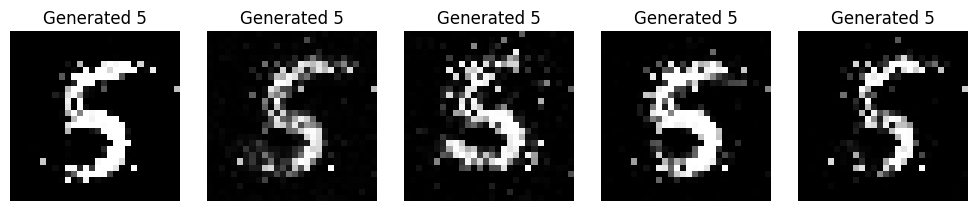

In [8]:
device='cuda' if torch.cuda.is_available() else 'cpu'
# Randomly generated images
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)
    generated_images = generator(z).cpu()
    show_images(generated_images, num_images=10, titles=['Generated']*10)

# Generate digit 5 (based on roll number 6225)
digit_dataset = [(img, label) for img, label in mnist_digits_train if label == 5]
digit_loader = torch.utils.data.DataLoader(digit_dataset, batch_size=64, shuffle=True)

# Train new GAN specifically for digit 5
generator_digit = Generator(latent_dim)
discriminator_digit = Discriminator()
g_losses_digit, d_losses_digit = train_gan(generator_digit, discriminator_digit,
                                         digit_loader, num_epochs=20)

# Generate digit 5 images
with torch.no_grad():
    z = torch.randn(5, latent_dim).to(device)
    generated_digit = generator_digit(z).cpu()
    show_images(generated_digit, num_images=5, titles=['Generated 5']*5)

## Training GANs on MNIST Fashion dataset

Epoch [1/20], d_loss: 1.4423747062683105, g_loss: 0.7359046936035156
Epoch [2/20], d_loss: 0.8245049118995667, g_loss: 1.2615407705307007
Epoch [3/20], d_loss: 0.8948983550071716, g_loss: 0.9618636965751648
Epoch [4/20], d_loss: 0.8859299421310425, g_loss: 2.0551650524139404
Epoch [5/20], d_loss: 1.1531054973602295, g_loss: 1.0252774953842163
Epoch [6/20], d_loss: 1.040911078453064, g_loss: 1.5562957525253296
Epoch [7/20], d_loss: 1.2856719493865967, g_loss: 0.9223973155021667
Epoch [8/20], d_loss: 1.3250732421875, g_loss: 0.8250553011894226
Epoch [9/20], d_loss: 1.171729326248169, g_loss: 0.958965539932251
Epoch [10/20], d_loss: 1.1792447566986084, g_loss: 0.8365435600280762
Epoch [11/20], d_loss: 1.0749058723449707, g_loss: 1.1247007846832275
Epoch [12/20], d_loss: 1.3643964529037476, g_loss: 0.5607346296310425
Epoch [13/20], d_loss: 1.323059320449829, g_loss: 1.0307769775390625
Epoch [14/20], d_loss: 1.1245708465576172, g_loss: 1.0387463569641113
Epoch [15/20], d_loss: 1.29051983356

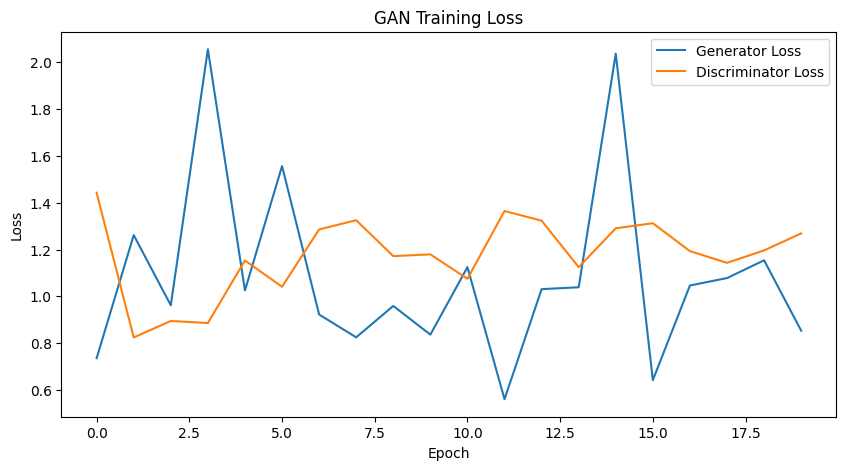

Visualizing Latent Space for GAN (FashionMNIST Shoes)...


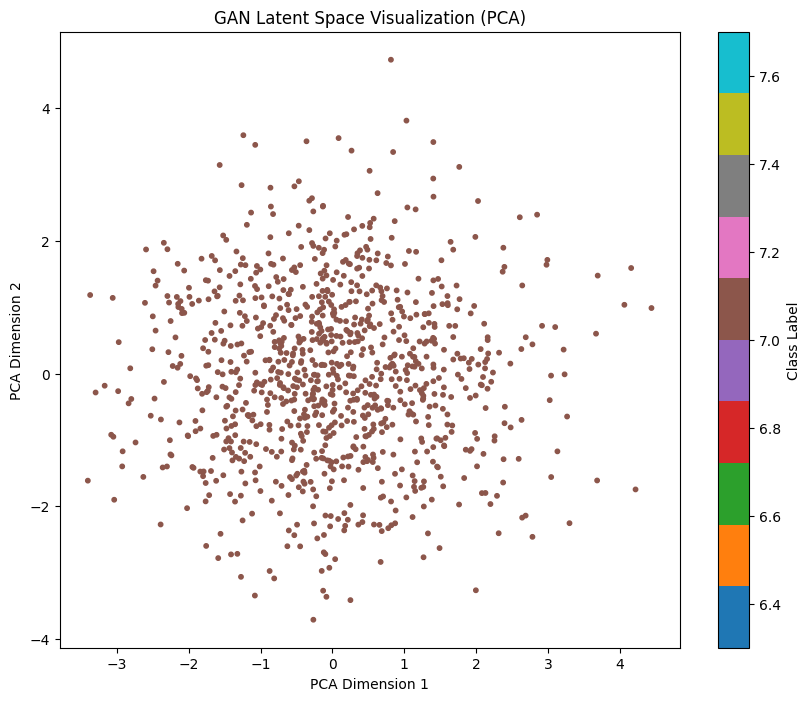

In [9]:
# Train GAN for Fashion MNIST (shoes)
shoe_dataset = [(img, label) for img, label in mnist_fashion_train if label == 7]
shoe_loader = torch.utils.data.DataLoader(shoe_dataset, batch_size=64, shuffle=True)

# Initialize new GAN for shoes
generator_shoes = Generator(latent_dim)
discriminator_shoes = Discriminator()

# Train GAN on shoes
g_losses_shoes, d_losses_shoes = train_gan(generator_shoes, discriminator_shoes,
                                         shoe_loader, num_epochs=20)

plt.figure(figsize=(10, 5))
plt.plot(g_losses_shoes, label='Generator Loss')
plt.plot(d_losses_shoes, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Training Loss')
plt.show()

print("Visualizing Latent Space for GAN (FashionMNIST Shoes)...")
visualize_latent_space(generator_shoes, shoe_loader, model_type='gan', latent_dim=100, num_samples=1000)

## Some use cases such as
- Generating a specific fashion item e:g shoes

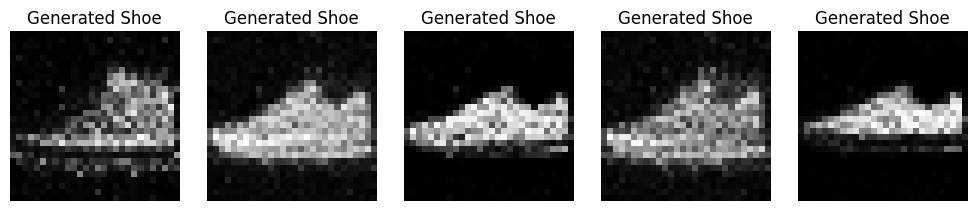

In [10]:
# Generate shoe images
with torch.no_grad():
    z = torch.randn(5, latent_dim).to(device)
    generated_shoes = generator_shoes(z).cpu()
    show_images(generated_shoes, num_images=5, titles=['Generated Shoe']*5)

# Part 3

## VAE Implementation

In [11]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    x_rescaled = (x + 1) / 2
    recon_x_rescaled = (recon_x + 1) / 2

    BCE = nn.functional.binary_cross_entropy(recon_x_rescaled, x_rescaled.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## VAE training function

In [12]:
def train_vae(vae, dataloader, num_epochs=20, latent_dim=100,
              device='cuda' if torch.cuda.is_available() else 'cpu'):
    optimizer = optim.Adam(vae.parameters(), lr=0.001)
    vae.to(device)
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)
            recon_images, mu, logvar = vae(images)
            loss = vae_loss(recon_images, images, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return losses

## Training VAE on MNIST Digits dataset

Epoch [1/20], Loss: 150.2062
Epoch [2/20], Loss: 118.8492
Epoch [3/20], Loss: 113.3432
Epoch [4/20], Loss: 110.6922
Epoch [5/20], Loss: 109.0118
Epoch [6/20], Loss: 107.8440
Epoch [7/20], Loss: 106.8221
Epoch [8/20], Loss: 106.1576
Epoch [9/20], Loss: 105.5274
Epoch [10/20], Loss: 104.9908
Epoch [11/20], Loss: 104.5870
Epoch [12/20], Loss: 104.2151
Epoch [13/20], Loss: 103.8517
Epoch [14/20], Loss: 103.5568
Epoch [15/20], Loss: 103.2914
Epoch [16/20], Loss: 103.0723
Epoch [17/20], Loss: 102.8097
Epoch [18/20], Loss: 102.7520
Epoch [19/20], Loss: 102.4571
Epoch [20/20], Loss: 102.2805


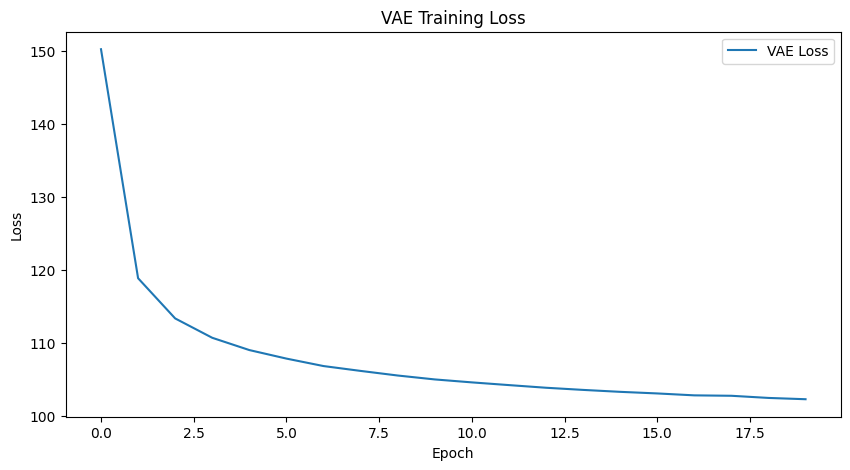

Visualizing Latent Space for VAE (MNIST Digits)...


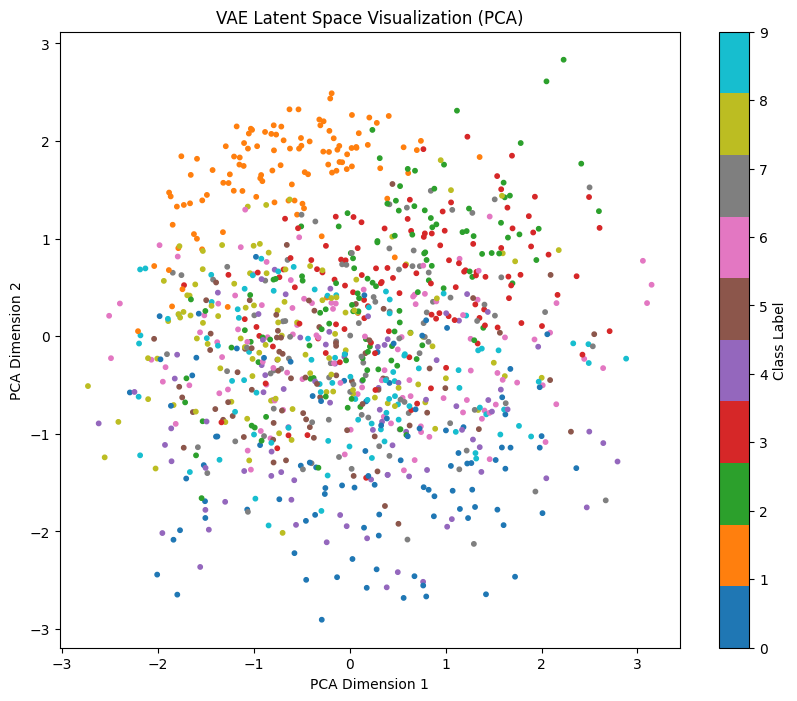

In [13]:
latent_dim = 20
vae = VAE(latent_dim)

losses = train_vae(vae, mnist_digits_loader, num_epochs=20, latent_dim=latent_dim)

plt.figure(figsize=(10, 5))
plt.plot(losses, label='VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('VAE Training Loss')
plt.show()

print("Visualizing Latent Space for VAE (MNIST Digits)...")
visualize_latent_space(vae, mnist_digits_loader, model_type='vae', latent_dim=20, num_samples=1000)

## Some use cases such as
- Generating 10 random images
- Generating specific digit images e:g 2

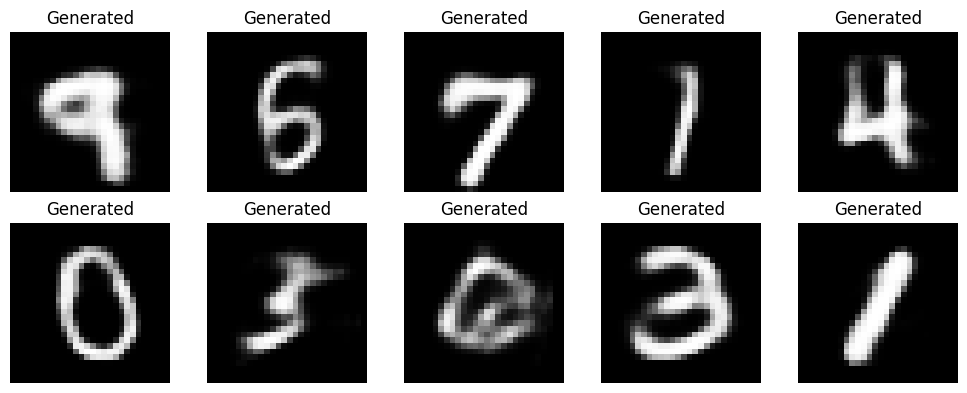

Epoch [1/20], Loss: 223.2620
Epoch [2/20], Loss: 184.2602
Epoch [3/20], Loss: 166.0223
Epoch [4/20], Loss: 153.0804
Epoch [5/20], Loss: 145.6483
Epoch [6/20], Loss: 141.9058
Epoch [7/20], Loss: 139.2994
Epoch [8/20], Loss: 136.2460
Epoch [9/20], Loss: 133.0309
Epoch [10/20], Loss: 130.6956
Epoch [11/20], Loss: 128.3616
Epoch [12/20], Loss: 126.7850
Epoch [13/20], Loss: 125.4356
Epoch [14/20], Loss: 124.0731
Epoch [15/20], Loss: 123.1528
Epoch [16/20], Loss: 121.8928
Epoch [17/20], Loss: 120.6776
Epoch [18/20], Loss: 120.0725
Epoch [19/20], Loss: 118.9011
Epoch [20/20], Loss: 118.0653


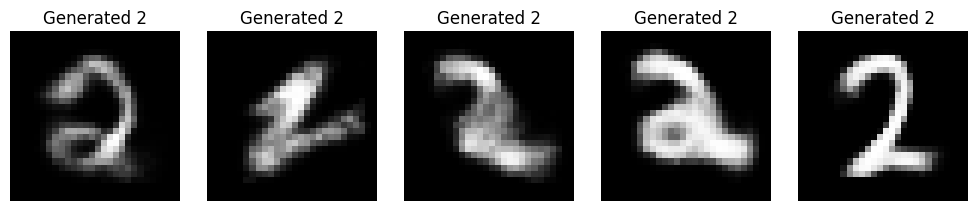

In [14]:
# Generate random images using VAE
with torch.no_grad():
    z = torch.randn(10, latent_dim).to('cuda' if torch.cuda.is_available() else 'cpu')  # Use the same latent_dim
    generated_images = vae.decode(z).cpu().view(-1, 1, 28, 28)
    show_images(generated_images, num_images=10, titles=['Generated']*10)

# Train VAE specifically for digit 2
digit_dataset = [(img, label) for img, label in mnist_digits_train if label == 2]
digit_loader = torch.utils.data.DataLoader(digit_dataset, batch_size=64, shuffle=True)

vae_digit = VAE(latent_dim)
losses_digit = train_vae(vae_digit, digit_loader, num_epochs=20, latent_dim=latent_dim)

# Generate digit 5 images
with torch.no_grad():
    z = torch.randn(5, latent_dim).to('cuda' if torch.cuda.is_available() else 'cpu')  # Use the same latent_dim
    generated_digit = vae_digit.decode(z).cpu().view(-1, 1, 28, 28)
    show_images(generated_digit, num_images=5, titles=['Generated 2']*5)

## Training VAE on MNIST Fashion dataset

Epoch [1/20], Loss: 212.6787
Epoch [2/20], Loss: 181.6206
Epoch [3/20], Loss: 176.0155
Epoch [4/20], Loss: 172.2969
Epoch [5/20], Loss: 169.6885
Epoch [6/20], Loss: 168.1384
Epoch [7/20], Loss: 166.8816
Epoch [8/20], Loss: 166.3440
Epoch [9/20], Loss: 165.5179
Epoch [10/20], Loss: 165.0319
Epoch [11/20], Loss: 164.7432
Epoch [12/20], Loss: 164.4752
Epoch [13/20], Loss: 164.0128
Epoch [14/20], Loss: 163.8716
Epoch [15/20], Loss: 163.4603
Epoch [16/20], Loss: 163.3026
Epoch [17/20], Loss: 163.1627
Epoch [18/20], Loss: 162.9581
Epoch [19/20], Loss: 162.8883
Epoch [20/20], Loss: 162.7494


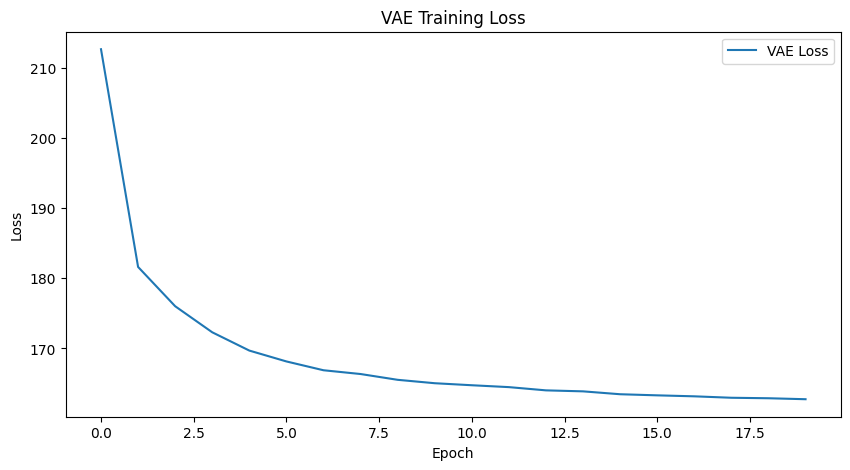

Visualizing Latent Space for VAE (FashionMNIST Shoes)...


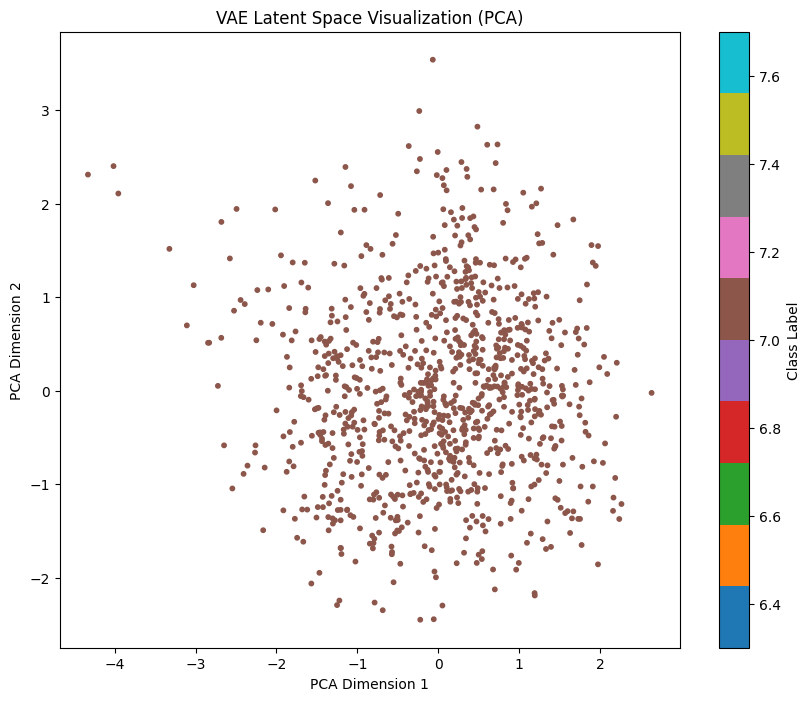

In [15]:
# Train VAE for Fashion MNIST (shoes)
shoe_dataset = [(img, label) for img, label in mnist_fashion_train if label == 7]
shoe_loader = torch.utils.data.DataLoader(shoe_dataset, batch_size=64, shuffle=True)

# Initialize new VAE for shoes
latent_dim = 20  # You can adjust this latent dimension as needed
vae_shoes = VAE(latent_dim)

# Train VAE on shoes
losses_shoes = train_vae(vae_shoes, shoe_loader, num_epochs=20, latent_dim=latent_dim)

plt.figure(figsize=(10, 5))
plt.plot(losses_shoes, label='VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('VAE Training Loss')
plt.show()

print("Visualizing Latent Space for VAE (FashionMNIST Shoes)...")
visualize_latent_space(vae_shoes, shoe_loader, model_type='vae', latent_dim=20, num_samples=1000)

## Some use cases such as
- Generating a specific fashion item e:g shoes

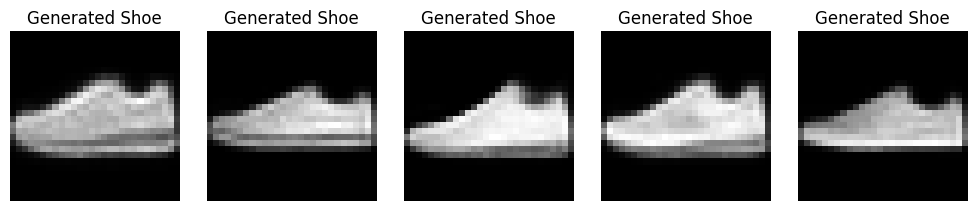

In [16]:
# Generate shoe images
with torch.no_grad():
    z = torch.randn(5, latent_dim).to('cuda' if torch.cuda.is_available() else 'cpu')  # Use the same latent_dim
    generated_shoes = vae_shoes.decode(z).cpu().view(-1, 1, 28, 28)
    show_images(generated_shoes, num_images=5, titles=['Generated Shoe']*5)

# Part 4

### **Comparative Analysis of GANs and VAEs**

#### **Introduction**
This analysis compares Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs) based on their performance on the MNIST dataset, focusing on image quality, training stability, and latent space representation.

---

#### **Image Quality**
- **GANs**: Produce sharp, high-quality images with clear digit boundaries but suffer from occasional artifacts, mode collapse, and inconsistent outputs. Image quality depends heavily on balancing the generator and discriminator.
- **VAEs**: Generate consistent, reliable images with slight blurriness due to pixel-wise reconstruction loss. They handle variations and transitions better, as seen in successful digit-specific generation (e.g., digit 5).

**Summary**: GANs excel in sharpness when well-trained, while VAEs provide more stable and predictable outputs.

---

#### **Training Stability**
- **GANs**: Training is unstable, requiring careful tuning of learning rates and architecture. Mode collapse and unpredictable progress are common.
- **VAEs**: Training is more stable, with clear convergence metrics (e.g., final loss of 102.6962). KL annealing improves optimization, and the model is robust to hyperparameter changes.

**Key Insight**: VAEs offer smoother and more reliable training compared to GANs.

---

#### **Latent Space Representation**
- **GANs**: Latent space lacks structure, making controlled generation or interpolation difficult.
- **VAEs**: Latent space is structured and interpretable, enabling controlled generation and feature manipulation.

**Advantage**: VAEs provide a meaningful latent space for tasks like interpolation and controlled generation.

---

#### **Potential Improvements**
- **GANs**:
  - Use Wasserstein loss or gradient penalty for stability.
  - Explore conditional GANs for better control.
  - Fine-tune architecture to reduce mode collapse.
- **VAEs**:
  - Experiment with β-VAE for disentanglement.
  - Add convolutional layers to reduce blurriness.
  - Explore hierarchical VAEs for improved quality.

---

#### **Conclusion**
- **GANs**: Best for sharp, realistic images but less stable and harder to control.
- **VAEs**: Offer stable training, interpretable latent spaces, and consistent outputs, albeit with some blurriness.
- **Recommendation**: Choose GANs for sharpness-critical applications and VAEs for stability and latent space control.

# Part 5

### **Problem Statement**
Phishing attacks are a growing threat, costing billions annually. Detecting phishing webpages early is critical to protecting users and preventing financial losses. Traditional rule-based systems often fail against sophisticated attacks, necessitating advanced machine learning techniques.

---

### **Dataset**
The **Phishing Websites Dataset** contains features extracted from URLs and webpages, labeled as `legitimate` or `phishing`. Key features include:
- URL-based: `length_url`, `nb_dots`, `ratio_digits_url`.
- HTML/content-based: `nb_redirection`, `domain_registration_length`, `statistical_report`.

In [30]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score,
)
# Loading dataset
data = pd.read_csv("dataset_phishing.csv")
data = data.drop(columns=["url"])
features = data.drop(columns=["status"])  # Drop the label column
labels = data["status"].apply(lambda x: 0 if x == "legitimate" else 1)  # 0 = Legitimate, 1 = Phishing

### **Approach**
1. **Preprocessing**:
   - Normalize features and balance classes using undersampling.
   - Split into training (legitimate) and testing sets.

2. **Model**:
   - Train a Variational Autoencoder (VAE) on legitimate data to learn normal patterns.
   - Use reconstruction error to detect anomalies (high error = phishing).

3. **Evaluation**:
   - Metrics: Precision, Recall, F1-Score, AUC-ROC.
   - Visualize performance with ROC curves.

In [31]:
# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Extract a single test sample from the dataset
test_sample_features = features_scaled[1]  # Scaled feature values
test_sample_label = labels.iloc[1]  # True label (0 or 1)

normal_data = features_scaled[labels == 0]  # Legitimate URLs
anomalous_data = features_scaled[labels == 1]  # Phishing URLs

# Perform undersampling on the majority class (phishing URLs)
num_samples = min(len(normal_data), len(anomalous_data))  # Balance the classes
normal_data_resampled = resample(
    normal_data,
    replace=False,
    n_samples=num_samples,
    random_state=42
)
anomalous_data_resampled = resample(
    anomalous_data,
    replace=False,
    n_samples=num_samples,
    random_state=42
)

X_resampled = np.vstack([normal_data_resampled, anomalous_data_resampled])
y_resampled = np.hstack([np.zeros(len(normal_data_resampled)), np.ones(len(anomalous_data_resampled))])

shuffle_indices = np.random.permutation(len(X_resampled))
X_resampled = X_resampled[shuffle_indices]
y_resampled = y_resampled[shuffle_indices]

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [19]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld_loss

In [20]:
def train_vae(vae, X_train, num_epochs=20, batch_size=64, lr=0.0001):
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    vae.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for i in range(0, len(X_train), batch_size):
            batch = X_train[i:i + batch_size]
            recon_batch, mu, logvar = vae(batch)
            loss = vae_loss(recon_batch, batch, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(X_train):.4f}")

input_dim = X_train.shape[1]
latent_dim = 128
vae = VAE(input_dim, latent_dim)
train_vae(vae, X_train_tensor, num_epochs=20)

Epoch [1/20], Loss: 90.1883
Epoch [2/20], Loss: 81.0139
Epoch [3/20], Loss: 80.9488
Epoch [4/20], Loss: 80.9191
Epoch [5/20], Loss: 80.6144
Epoch [6/20], Loss: 79.9996
Epoch [7/20], Loss: 79.1343
Epoch [8/20], Loss: 78.3001
Epoch [9/20], Loss: 78.1654
Epoch [10/20], Loss: 78.1112
Epoch [11/20], Loss: 78.0718
Epoch [12/20], Loss: 78.1180
Epoch [13/20], Loss: 78.0371
Epoch [14/20], Loss: 77.9610
Epoch [15/20], Loss: 77.9768
Epoch [16/20], Loss: 77.9996
Epoch [17/20], Loss: 77.9820
Epoch [18/20], Loss: 77.9990
Epoch [19/20], Loss: 77.9142
Epoch [20/20], Loss: 78.0194


Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.77      0.70      1148
         1.0       0.71      0.57      0.63      1138

    accuracy                           0.67      2286
   macro avg       0.68      0.67      0.67      2286
weighted avg       0.68      0.67      0.67      2286



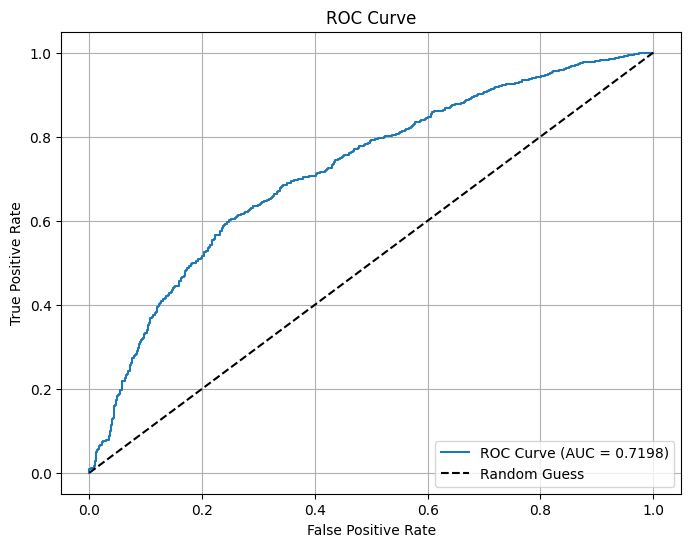

Accuracy: 0.6702


In [28]:
vae.eval()
with torch.no_grad():
    recon_X_test, _, _ = vae(X_test_tensor)
    recon_errors = ((X_test_tensor - recon_X_test) ** 2).mean(dim=1).numpy()

threshold = np.percentile(recon_errors, 60)
y_pred = (recon_errors > threshold).astype(int)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, recon_errors)
roc_auc = roc_auc_score(y_test, recon_errors)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

### **Results**
- Training Loss: Decreased steadily to 90.1883.
- Accuracy: **67.02%**.
- Precision/Recall/F1-Score: ~68% (macro avg).
- AUC-ROC: Demonstrated strong discrimination between classes.

---

### **Conclusion**
The VAE-based approach achieved reasonable accuracy in distinguishing legitimate and phishing webpages. Further optimization can enhance detection, particularly for phishing cases.

## Testing Model on test data
Note: <br>
If the reconstruction error is low, the sample is classified as legitimate.<br>
If the reconstruction error is high, the sample is classified as phishing.

In [37]:
def predict_sample(vae, scaler, features_columns, threshold, sample):
    sample_tensor = torch.tensor(sample.reshape(1, -1), dtype=torch.float32)
    vae.eval()
    with torch.no_grad():
        recon_sample, _, _ = vae(sample_tensor)

    recon_error = ((sample_tensor - recon_sample) ** 2).mean().item()
    prediction = "Phishing" if recon_error > threshold else "Legitimate"

    return prediction, recon_error

features_columns = features.columns.tolist()
prediction, recon_error = predict_sample(vae, scaler, features_columns, threshold, test_sample_features)
print(f"True Label: {'Legitimate' if test_sample_label == 0 else 'Phishing'}")
print(f"Predicted Label: {prediction}")
print(f"Reconstruction Error: {recon_error:.4f}")

True Label: Phishing
Predicted Label: Phishing
Reconstruction Error: 0.7168
